## 実験概要

* single petal式、1000枚の合成画像で実験
* random aug使用なし
* スケールの正規化あり


In [7]:
!nvidia-smi

Thu Sep 21 18:57:17 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 520.61.05    Driver Version: 520.61.05    CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:1A:00.0 Off |                  N/A |
| 30%   31C    P8    28W / 350W |  18977MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  On   | 00000000:28:00.0 Off |                  N/A |
| 30%   

In [1]:
import os
import torch
import matplotlib.pyplot as plt
# import pytorch_lightning as pl
import segmentation_models_pytorch as smp
print('torch', torch.__version__)
# print('pl', pl.__version__)
print('smp', smp.__version__)
import numpy as np

from pprint import pprint
from torch.utils.data import DataLoader
import segmentation_models_pytorch.utils as smp_utils

ModuleNotFoundError: No module named 'pytorch_lightning'

## データセット作成

In [9]:
import glob
import shutil

num_synthe = 1000

# paths = sorted(glob.glob('../data/synthetic_flower/synthetic/single_petal_v2/*'))
# for path in paths[:num_synthe]:
#     shutil.copy(path, path.replace('single_petal_v2', f'single_{num_synthe}'))

# paths = sorted(glob.glob('../data/synthetic_flower/synthetic_mask/single_petal_v2/*'))
# for path in paths[:num_synthe]:
#     shutil.copy(path, path.replace('single_petal_v2', f'single_{num_synthe}'))

## 本実験

In [10]:
exp_name = 'exp_15'

In [11]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class OneHotTensorEncode(object):
    def __init__(self, n_classes=11):
        self.n_classes = n_classes

    def __call__(self, mask, debug=False):
        """
        Convert a 1-channel grayscale PIL image with n_classes unique values 
        into an n_classes-channel one-hot encoded tensor.
        """
        mask = np.array(mask)
        one_hot = torch.zeros(self.n_classes, mask.shape[0], mask.shape[1], dtype=torch.float32)
        for i in range(self.n_classes):
            one_hot[i, :, :] = torch.tensor(mask == i, dtype=torch.float32)
            if debug:
                count = np.sum(mask == i)
                print(f"Number of pixels with value {i}: {count}")
            
                plt.imshow(one_hot[i, :, :].numpy(), cmap='gray')
                plt.title(f"Class {i} One-hot Encoded Channel")
                plt.colorbar()
                plt.show()
        return one_hot

from torchvision.transforms import ToPILImage

class RandomTransformsDual:
    """
    画像とマスクの両方にランダム変換を適用するクラス
    """
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, mask):
        # 元の型を保存
        original_img_type = type(img)
        original_mask_type = type(mask)

        # Imageオブジェクトか確認し、テンソルに変換
        if isinstance(img, Image.Image):
            img = transforms.ToTensor()(img)
        if isinstance(mask, Image.Image):
            mask = transforms.ToTensor()(mask)

        # 変換前のshapeを保存
        img_shape = img.shape
        mask_shape = mask.shape

        seed = torch.randint(2147483647, size=())  # 大きな数でランダムシードを設定
        torch.manual_seed(seed)  # 同じシードを使用して、画像とマスクの両方に同じ変換を確実に適用する

        for t in self.transforms:
            img = t(img)

        torch.manual_seed(seed)
        for t in self.transforms:
            mask = t(mask)

        # 変換後のshapeが一致するか確認
        assert img.shape == img_shape, "Image shape mismatch before and after transform"
        assert mask.shape == mask_shape, "Mask shape mismatch before and after transform"

        # 元の型に戻す
        if original_img_type == Image.Image:
            img = ToPILImage()(img)
        if original_mask_type == Image.Image:
            mask = ToPILImage()(mask)

        return img, mask

    
def custom_crop(image, trim_margin=180):
    return image.crop((trim_margin, trim_margin, image.width - trim_margin, image.height - trim_margin))

class SegmentationDataset(Dataset):
    def __init__(self, root_dir, image_folder, mask_folder, image_transforms=None, mask_transforms=None, random_transforms=None):
        self.root_dir = root_dir
        self.image_folder = image_folder
        self.mask_folder = mask_folder
        self.image_transforms = image_transforms
        self.mask_transforms = mask_transforms
        self.random_transforms = random_transforms
        self.image_files = [file for file in os.listdir(os.path.join(root_dir, image_folder)) if os.path.isfile(os.path.join(root_dir, image_folder, file))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        image_path = os.path.join(self.root_dir, self.image_folder, self.image_files[index])
        mask_path = os.path.join(self.root_dir, self.mask_folder, self.image_files[index].replace(".jpg", ".png"))
        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.random_transforms:
            image, mask = self.random_transforms(image, mask)

        if self.image_transforms:
            image = self.image_transforms(image)

        if self.mask_transforms:
            mask = self.mask_transforms(mask)

        return image, mask

random_transforms = RandomTransformsDual([
    transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(180)  # ±180度のランダムな回転
])

image_transforms = transforms.Compose([
    transforms.Lambda(custom_crop),
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

mask_transforms = transforms.Compose([
    transforms.Lambda(custom_crop),
    transforms.Resize((512, 512)),
    OneHotTensorEncode(n_classes=11),
])

root_dir = "../data/synthetic_flower"
image_folder = "synthetic/single_1000"
mask_folder = "synthetic_mask/single_1000"


dataset = SegmentationDataset(root_dir, image_folder, mask_folder, image_transforms, mask_transforms, random_transforms)
dataset_size = len(dataset)

train_ratio = 0.7
val_ratio = 0.3

train_size = int(train_ratio * dataset_size)
val_size = int(val_ratio * dataset_size)
# test_size = dataset_size - train_size - val_size

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
# train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# データローダーの作成
batch_size = 8
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
# test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


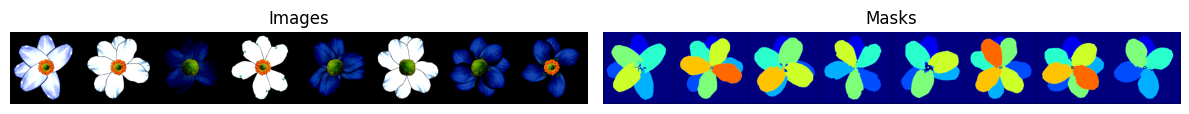

In [12]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import torch

def apply_colormap_to_mask(mask_tensor):
    overlay = np.zeros((*mask_tensor.shape[1:], 3))
    for i in range(n_channels):
        mask_area = mask_tensor[i].numpy() > 0.5
        overlay[mask_area] = colors[i][:3]
    return overlay


# 異なるチャネルのためのカラーマップ
n_channels = 11
colors = plt.cm.jet(np.linspace(0, 1, n_channels))

# データローダーから一つのバッチを取得
dataiter = iter(train_dataloader)
images, labels = dataiter.next()

# 画像のグリッドを作成
grid_images = vutils.make_grid(images)
plt.figure(figsize=(12, 6))

# 画像を描画
plt.subplot(1, 2, 1)
plt.title("Images")
plt.imshow(grid_images.permute(1, 2, 0))
plt.axis('off')

# ラベル（マスク）をテンソルに変換
# ここでapply_colormap_to_mask関数は、マスクに適用する任意のカラーマップ変換関数です。
labels_colored = [apply_colormap_to_mask(label) for label in labels]
labels_colored = [torch.tensor(label, dtype=torch.float32).permute(2, 0, 1) for label in labels_colored]
labels_colored = torch.stack(labels_colored)  # リストをテンソルにスタック

# ラベルのグリッドを作成
grid_labels = vutils.make_grid(labels_colored)

# ラベル（マスク）を描画
plt.subplot(1, 2, 2)
plt.title("Masks")
# plt.imshow(grid_labels)
plt.imshow(grid_labels.permute(1, 2, 0))
plt.axis('off')

plt.tight_layout()
plt.show()


In [13]:
import segmentation_models_pytorch as smp

# パラメーター
ENCODER = "efficientnet-b4"
ENCODER_WEIGHTS = "imagenet"
ACTIVATION = "softmax2d"
CLASS_NUM = 11 # segmentationの正解ラベル数

# モデル定義
model = smp.UnetPlusPlus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=CLASS_NUM, 
    activation=ACTIVATION,
)


# 学習時の設定
DEVICE = "cuda:7"
# BATCH_SIZE = 8
loss = smp.utils.losses.DiceLoss(ignore_channels=[0])
# loss = smp.utils.losses.DiceLoss()
metrics = [smp.utils.metrics.IoU(threshold=0.5, ignore_channels=[0])]
# metrics = [smp.utils.metrics.IoU(threshold=0.5)]
optimizer = torch.optim.Adam([dict(params=model.parameters(), lr=0.0001)])

train_epoch = smp_utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp_utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)


In [14]:
max_score = 0
patience = 0

# 学習実行
for i in range(50):
    print(f"Epoch:{i+1}")
    train_logs = train_epoch.run(train_dataloader)
    valid_logs = valid_epoch.run(val_dataloader)

    # IoUスコアが最高値が更新されればモデルを保存
    if max_score < valid_logs["iou_score"]:
        max_score = valid_logs["iou_score"]
        torch.save(model, f"./best_model_{exp_name}.pth")
        print('============== [updated best model] ==============')
        patience = 0
    else:
        patience += 1
        if patience == 5:
            break


Epoch:1
valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 38/38 [00:14<00:00,  2.70it/s, dice_loss - 0.7505, iou_score - 0.2758]
============== [updated best model] ==============
Epoch:2
valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 38/38 [00:13<00:00,  2.85it/s, dice_loss - 0.5305, iou_score - 0.461]
============== [updated best model] ==============
Epoch:3
valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 38/38 [00:13<00:00,  2.85it/s, dice_loss - 0.4016, iou_score - 0.6143]
============== [updated best model] ==============
Epoch:4
valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████

valid: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 38/38 [00:13<00:00,  2.77it/s, dice_loss - 0.05832, iou_score - 0.8985]
============== [updated best model] ==============
Epoch:18
valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 38/38 [00:14<00:00,  2.67it/s, dice_loss - 0.0579, iou_score - 0.8985]
============== [updated best model] ==============
Epoch:19
valid: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 38/38 [00:14<00:00,  2.66it/s, dice_loss - 0.05744, iou_score - 0.8986]
============== [updated best model] ==============
Epoch:20
valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████

valid: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 38/38 [00:13<00:00,  2.86it/s, dice_loss - 0.05065, iou_score - 0.9066]
============== [updated best model] ==============
Epoch:34
valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 38/38 [00:13<00:00,  2.77it/s, dice_loss - 0.0512, iou_score - 0.9056]
Epoch:35
valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 38/38 [00:13<00:00,  2.74it/s, dice_loss - 0.05145, iou_score - 0.905]
Epoch:36
valid: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 38/38 [00:14<00:00,  2.66it/s, dice_loss - 0.05038, iou_score - 0.

In [15]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class OneHotTensorEncode(object):
    def __init__(self, n_classes=11):
        self.n_classes = n_classes

    def __call__(self, mask, debug=False):
        """
        Convert a 1-channel grayscale PIL image with n_classes unique values 
        into an n_classes-channel one-hot encoded tensor.
        """
        mask = np.array(mask)
        one_hot = torch.zeros(self.n_classes, mask.shape[0], mask.shape[1], dtype=torch.float32)
        for i in range(self.n_classes):
            one_hot[i, :, :] = torch.tensor(mask == i, dtype=torch.float32)
            if debug:
                count = np.sum(mask == i)
                print(f"Number of pixels with value {i}: {count}")
            
                plt.imshow(one_hot[i, :, :].numpy(), cmap='gray')
                plt.title(f"Class {i} One-hot Encoded Channel")
                plt.colorbar()
                plt.show()
        return one_hot

class RandomTransformsDual:
    """
    画像とマスクの両方にランダム変換を適用するクラス
    """
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, mask):
        seed = np.random.randint(2147483647)  # 大きな数でランダムシードを設定
        np.random.seed(seed)  # 同じシードを使用して、画像とマスクの両方に同じ変換を確実に適用する

        for t in self.transforms:
            img = t(img)

        np.random.seed(seed)
        for t in self.transforms:
            mask = t(mask)

        return img, mask
    
# def custom_crop(image, trim_margin=0):
#     return image.crop((trim_margin, trim_margin, image.width - trim_margin, image.height - trim_margin))

class CustomCropTransform:
    def __init__(self, trim_margin=0):
        self.trim_margin = trim_margin
    
    def __call__(self, image):
        trim_margin = self.trim_margin
        return image.crop((trim_margin, trim_margin, image.width - trim_margin, image.height - trim_margin))


class SegmentationDataset(Dataset):
    def __init__(self, root_dir, image_folder, mask_folder, image_transforms=None, mask_transforms=None, random_transforms=None):
        self.root_dir = root_dir
        self.image_folder = image_folder
        self.mask_folder = mask_folder
        self.image_transforms = image_transforms
        self.mask_transforms = mask_transforms
        self.random_transforms = random_transforms
        self.image_files = [file for file in os.listdir(os.path.join(root_dir, image_folder)) if os.path.isfile(os.path.join(root_dir, image_folder, file))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        image_path = os.path.join(self.root_dir, self.image_folder, self.image_files[index])
        mask_path = os.path.join(self.root_dir, self.mask_folder, self.image_files[index].replace(".jpg", ".png"))
        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.random_transforms:
            image, mask = self.random_transforms(image, mask)

        if self.image_transforms:
            image = self.image_transforms(image)

        if self.mask_transforms:
            mask = self.mask_transforms(mask)

        return image, mask

random_transforms = RandomTransformsDual([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(180)  # ±180度のランダムな回転
])

image_transforms = transforms.Compose([
   CustomCropTransform(trim_margin=0),
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

mask_transforms = transforms.Compose([
    CustomCropTransform(trim_margin=0),
    transforms.Resize((512, 512)),
    OneHotTensorEncode(n_classes=11),
])

root_dir = "../data/"
image_folder = "main-annotation-sample_img"
mask_folder = "main-annotation-sample_entire_mask_pad"


dataset = SegmentationDataset(root_dir, image_folder, mask_folder, image_transforms, mask_transforms)
dataset_size = len(dataset)

train_ratio = 0.7
val_ratio = 0.3

train_size = int(train_ratio * dataset_size)
val_size = int(val_ratio * dataset_size)
# test_size = dataset_size - train_size - val_size

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
# train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# データローダーの作成
batch_size = 8
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
# test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)


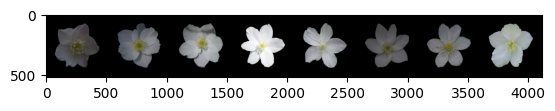

In [16]:
def denormalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    tensor = tensor.clone()  # 元のテンソルを変更しないようにする
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

# データローダーから一つのバッチを取得
dataiter = iter(train_dataloader)
images, labels = dataiter.next()

# 画像を表示する
import matplotlib.pyplot as plt
import torchvision.utils as vutils

# バッチから画像を作成し、表示する
grid = vutils.make_grid([denormalize(img.clone()) for img in images])
plt.imshow(grid.permute(1, 2, 0))
plt.show()


In [17]:
import segmentation_models_pytorch as smp

# パラメーター
ENCODER = "efficientnet-b4"
ENCODER_WEIGHTS = "imagenet"
ACTIVATION = "softmax2d"
CLASS_NUM = 11 # segmentationの正解ラベル数

# モデル定義
# model = smp.UnetPlusPlus(
#     encoder_name=ENCODER, 
#     encoder_weights=ENCODER_WEIGHTS, 
#     classes=CLASS_NUM, 
#     activation=ACTIVATION,
# )
model = torch.load(f"./best_model_{exp_name}.pth")


# 学習時の設定
DEVICE = "cuda:7"
# BATCH_SIZE = 8
loss = smp.utils.losses.DiceLoss(ignore_channels=[0])
# loss = smp.utils.losses.DiceLoss()
metrics = [smp.utils.metrics.IoU(threshold=0.5, ignore_channels=[0])]
# metrics = [smp.utils.metrics.IoU(threshold=0.5)]
optimizer = torch.optim.Adam([dict(params=model.parameters(), lr=0.000005)])

train_epoch = smp_utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp_utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)


In [18]:
max_score = 0
patience = 0

# 学習実行
for i in range(300):
    print(f"Epoch:{i+1}")
    train_logs = train_epoch.run(train_dataloader)
    valid_logs = valid_epoch.run(val_dataloader)

    # IoUスコアが最高値が更新されればモデルを保存
    if max_score < valid_logs["iou_score"]:
        max_score = valid_logs["iou_score"]
        torch.save(model, f"./best_model_{exp_name}_finetune.pth")
        print('============== [updated best model] ==============')
        patience = 0
    else:
        patience += 1
        if patience == 20:
            break


Epoch:1
valid: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.74it/s, dice_loss - 0.8043, iou_score - 0.1089]
============== [updated best model] ==============
Epoch:2
valid: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.73it/s, dice_loss - 0.7998, iou_score - 0.1117]
============== [updated best model] ==============
Epoch:3
valid: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.73it/s, dice_loss - 0.7958, iou_score - 0.1142]
============== [updated best model] ==============
Epoch:4
valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████

valid: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.68it/s, dice_loss - 0.7526, iou_score - 0.1414]
Epoch:33
valid: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.77it/s, dice_loss - 0.7525, iou_score - 0.1413]
Epoch:34
valid: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.72it/s, dice_loss - 0.751, iou_score - 0.1421]
============== [updated best model] ==============
Epoch:35
valid: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.72it/s, dice_loss - 0.7506, iou_score - 0.

valid: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.64it/s, dice_loss - 0.7356, iou_score - 0.1544]
============== [updated best model] ==============
Epoch:64
valid: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.67it/s, dice_loss - 0.7347, iou_score - 0.1548]
============== [updated best model] ==============
Epoch:65
valid: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.78it/s, dice_loss - 0.7338, iou_score - 0.1554]
============== [updated best model] ==============
Epoch:66
valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████

valid: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.78it/s, dice_loss - 0.7207, iou_score - 0.1639]
============== [updated best model] ==============
Epoch:96
valid: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.79it/s, dice_loss - 0.7211, iou_score - 0.1635]
Epoch:97
valid: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.72it/s, dice_loss - 0.7208, iou_score - 0.1638]
Epoch:98
valid: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.84it/s, dice_loss - 0.7202, iou_score - 0.

## test data 可視化

In [19]:
best_model = torch.load(f"./best_model_{exp_name}_finetune.pth")
best_model.eval()

predictions = []

with torch.no_grad():
    for batch in val_dataloader:
        img, mask = batch
        img = img.to(DEVICE)
        outputs = best_model(img)
        predictions.append(outputs.cpu())

# 全ての予測をひとつのテンソルにまとめる
predictions = torch.cat(predictions, dim=0)

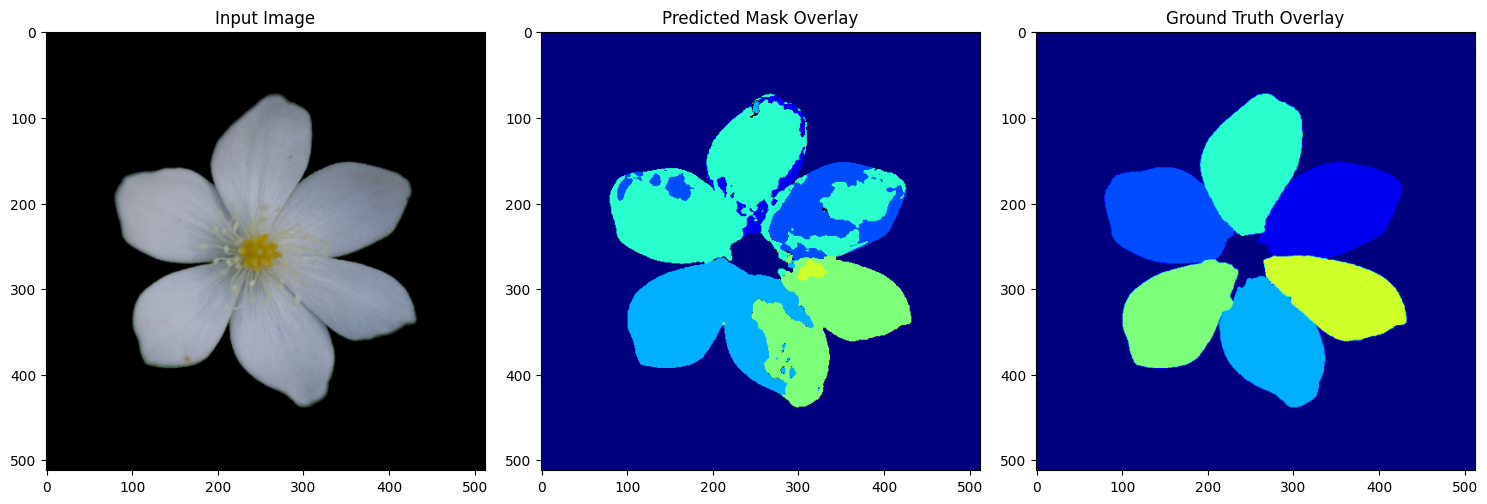

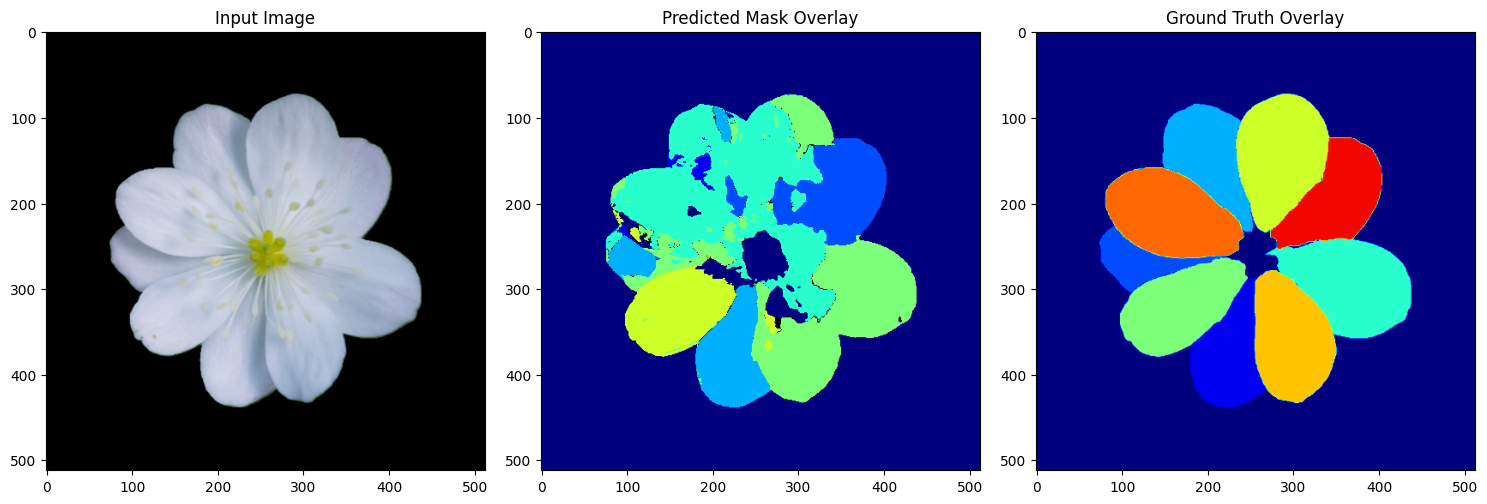

In [20]:
def apply_colormap_to_mask(mask_tensor):
    overlay = np.zeros((*mask_tensor.shape[1:], 3))
    for i in range(n_channels):
        mask_area = mask_tensor[i].numpy() > 0.5
        overlay[mask_area] = colors[i][:3]
    return overlay

for random_index in range(len(val_dataloader)):
    prediction = predictions[random_index]  
    img, true_mask = val_dataset[random_index]

    n_channels = 11

    # 異なるチャネルのためのカラーマップ
    colors = plt.cm.jet(np.linspace(0, 1, n_channels))
    predicted_overlay = apply_colormap_to_mask(prediction)
    true_mask_overlay = apply_colormap_to_mask(true_mask)

    # 描画
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(denormalize(img).permute(1, 2, 0).numpy())
    plt.title('Input Image')

    plt.subplot(1, 3, 2)
    plt.imshow(predicted_overlay)
    plt.title('Predicted Mask Overlay')

    plt.subplot(1, 3, 3)
    plt.imshow(true_mask_overlay)
    plt.title('Ground Truth Overlay')

    plt.tight_layout()
    plt.show()


NameError: name 'mpatches' is not defined

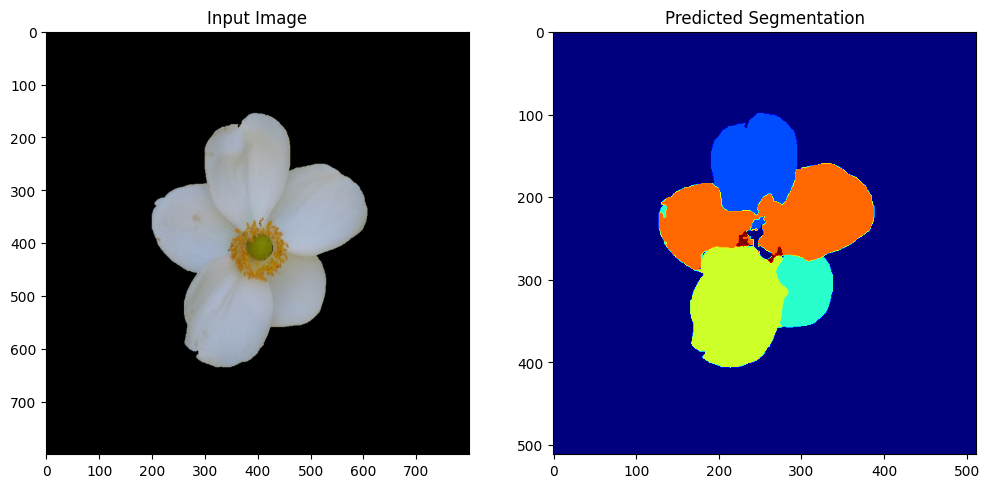

In [21]:
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torchvision import transforms

def load_images(image_paths, transforms):
    """
    画像のパスのリストを入力として、前処理を行ったテンソルのリストを返す関数
    """
    image_tensors = []
    for image_path in image_paths:
        image = Image.open(image_path).convert("RGB")
        image_tensor = transforms(image)
        image_tensor = image_tensor.unsqueeze(0)  # バッチ次元を追加
        image_tensors.append(image_tensor)
    
    return torch.cat(image_tensors, dim=0)

def visualize_predictions(model, image_tensor, original_images):
    """
    画像のテンソルとモデルを入力として、推論結果を可視化する関数
    """
    with torch.no_grad():
        predictions = model(image_tensor)
    
    for i, prediction in enumerate(predictions):
        plt.figure(figsize=(12, 6))
        
        # 入力画像
        plt.subplot(1, 2, 1)
        plt.imshow(original_images[i])
        plt.title('Input Image')
        
        # 推論結果
        plt.subplot(1, 2, 2)
        predicted_mask = prediction.argmax(dim=0)  # 各位置で最も高い確信度のクラスを取得
        plt.imshow(predicted_mask.cpu().numpy(), cmap='jet')  # カラーマップとして'jet'を使用
        plt.title('Predicted Segmentation')

        unique_labels = np.unique(predicted_mask.cpu().numpy())
        legend_patches = [mpatches.Patch(color=plt.cm.jet(label / np.max(unique_labels)), label=str(label)) for label in unique_labels]
        plt.legend(handles=legend_patches, title="Label IDs")
        plt.title('Predicted Segmentation')

        plt.tight_layout()
        plt.show()

# 使用例
best_model = torch.load(f"./best_model_{exp_name}.pth")
best_model.eval()
best_model.to(DEVICE)  # 念のためモデルをデバイスへ移動

image_transforms = transforms.Compose([
    transforms.Resize((512, 512)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

image_paths = ['../data/030_0_1.jpg', '../data/000_0_1_padded.jpg',]  # 任意の画像のパスリスト
original_images = [Image.open(path) for path in image_paths]
image_tensors = load_images(image_paths, image_transforms)
image_tensors = image_tensors.to(DEVICE)

visualize_predictions(best_model, image_tensors, original_images)

# 使用例
best_model = torch.load(f"./best_model_{exp_name}_finetune.pth")
best_model.eval()
best_model.to(DEVICE)  # 念のためモデルをデバイスへ移動

image_transforms = transforms.Compose([
    transforms.Resize((512, 512)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

image_paths = ['../data/030_0_1.jpg', '../data/000_0_1_padded.jpg',]  # 任意の画像のパスリスト
original_images = [Image.open(path) for path in image_paths]
image_tensors = load_images(image_paths, image_transforms)
image_tensors = image_tensors.to(DEVICE)

visualize_predictions(best_model, image_tensors, original_images)


## 上の処理の一般化

## 参考としてtrain dataで確認

In [ ]:
# best_model = torch.load("./best_model_finetune.pth")
# best_model.eval()

predictions = []
train_dataloader_visualization = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

with torch.no_grad():
    for batch in train_dataloader_visualization:
        img, mask = batch
        img = img.to(DEVICE)
        outputs = best_model(img)
        predictions.append(outputs.cpu())

# 全ての予測をひとつのテンソルにまとめる
predictions = torch.cat(predictions, dim=0)

In [ ]:
for random_index in range(len(train_dataloader_visualization)):
    prediction = predictions[random_index]  
    img, true_mask = train_dataset[random_index]

    n_channels = 11

    # 異なるチャネルのためのカラーマップ
    colors = plt.cm.jet(np.linspace(0, 1, n_channels))
    predicted_overlay = apply_colormap_to_mask(prediction)
    true_mask_overlay = apply_colormap_to_mask(true_mask)

    # 描画
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(denormalize(img).permute(1, 2, 0).numpy())
    plt.title('Input Image')

    plt.subplot(1, 3, 2)
    plt.imshow(predicted_overlay)
    plt.title('Predicted Mask Overlay')

    plt.subplot(1, 3, 3)
    plt.imshow(true_mask_overlay)
    plt.title('Ground Truth Overlay')

    plt.tight_layout()
    plt.show()
